In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import palettable
import cmocean

In [4]:
from IPython.display import clear_output

In [5]:
import sys
import pathlib

### import the local package 

In [6]:
sys.path.append('../../')

In [7]:
import seaborn as sns

In [8]:
from ICU_Water_Watch import plot, utils, verification, geo, C3S, domains

In [9]:
from datetime import datetime, timedelta
from calendar import month_abbr

In [10]:
import numpy as np
import pandas as pd 
import xarray as xr
import cartopy.crs as ccrs 
import regionmask

### climpred HindcastEnsemble Class + logging

In [11]:
from climpred import HindcastEnsemble
import logging

### progress bar for dask compute 

In [12]:
from dask.diagnostics import ProgressBar

### path definitions 

In [13]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [14]:
fig_path = CWD.parents[1] / 'figures/verification/SST'

In [15]:
fig_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/verification/SST')

### parameters for papermill

In [16]:
domain_name = 'Water_Watch'
use_verif = 'oisst'
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']
varname = 'sst'
period = 'seasonal' # 'seasonal' or 'monthly'
year_start = 1993 
year_end = 2016
obs_to_1deg = False
drop_inits = [datetime(1997,8,1), datetime(1993,1,1)] # initial times to drop because of issues in NCEP and UKMO respectively
climpred_verbose = False

### logging, to see what `climpred` is doing under the hood, if `climpred_verbose` is set to True, then all inits and corresponding verif times are printed

### Note: setting it to True causes issues with Matplotlib, which outputs endless debug messages related to the font manager, so setting it to `False` is safer

In [17]:
logger = logging.getLogger()

if climpred_verbose: 
    
    logger.setLevel(logging.DEBUG)
    
else: 
    
    logger.setLevel(logging.INFO)

### dictionnary of domains 

In [18]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [19]:
domain = domains.domains[domain_name]

### creates a map delineating the validation domain 

In [20]:
area = geo.gpd_from_domain(*domain)

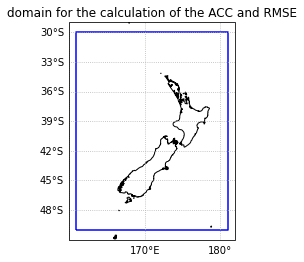

In [21]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
area.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='b')
ax.coastlines(resolution='10m'); 
ax.set_title('domain for the calculation of the ACC and RMSE')
gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

### reads in the verification dataset 

In [21]:
if use_verif == 'ersst': 
    _, dset_obs = verification.get_ERSST(access='opendap', start=year_start, end=year_end, detrend=True)
elif use_verif == 'oisst': 
    _, dset_obs = verification.get_OISST(start=year_start, end=year_end, detrend=True)

### regrid to 1deg X 1deg (if `obs_to_1deg` is set to True)

In [22]:
if obs_to_1deg: 
    dset_obs = utils.interp_to_1x(dset_obs)

### now selects domain 

In [23]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [24]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float64 0.3522 0.358 0.3211 ... -0.04658 -0.11

### creates a mask from the observational dataset 

In [25]:
mask_obs = dset_obs.mean(dim='time')

In [26]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [27]:
mask_obs = mask_obs.rename({varname:'mask'})['mask']

### plots the mask 

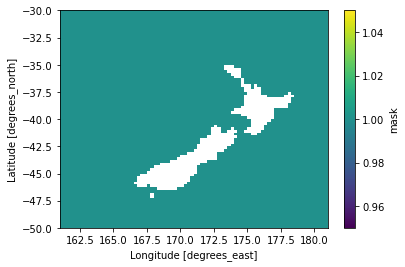

In [28]:
mask_obs.plot()

### calculates seasonal averages if 'seasonal' 

In [29]:
if period == 'seasonal': 
    dset_obs = dset_obs.rolling({'time':3}, min_periods=3).mean('time')
    dset_obs = dset_obs.isel(time=slice(2, None))

### Now reads in the GCM hindcasts (reforecasts)

In [30]:
MME = C3S.get_GCMs(GCM=GCMs, varname=varname, domain=domain)

---------------------------------------------------
reading ECMWF

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST/ensemble_seas_forecasts_sst_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST/ensemble_seas_forecasts_sst_from_2016_12_ECMWF.netcdf
---------------------------------------------------
reading UKMO

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST/ensemble_seas_forecasts_sst_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST/ensemble_seas_forecasts_sst_from_2016_12_UKMO.netcdf
---------------------------------------------------
reading METEO_FRANCE

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/METEO_FRANCE/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/METEO_FRANCE/SST/ensemble_seas_forecasts_sst_

### drop the problematic initialisation times from the dataset 

In [31]:
for drop_date in drop_inits: 
    MME = MME.drop_sel(time=drop_date)

In [32]:
MME

,Array,Chunk
Bytes,16.84 MiB,8.61 kiB
Shape,"(7, 286, 5, 21, 21)","(1, 1, 5, 21, 21)"
Count,58114 Tasks,2002 Chunks
Type,float32,numpy.ndarray


### calculates seasonal averages if 'seasonal'

In [33]:
if period == 'seasonal': 
    MME = MME.rolling({'step':3}, min_periods=3).mean('step')
    MME = MME.sel(step=slice(3, None))

In [34]:
MME

,Array,Chunk
Bytes,20.21 MiB,10.34 kiB
Shape,"(7, 286, 3, 21, 21)","(1, 1, 3, 21, 21)"
Count,140694 Tasks,2002 Chunks
Type,float64,numpy.ndarray


### transpose to have GCM and time as the first 2 dimensions 

In [35]:
MME = MME.transpose("GCM", "time", "step", "lat", "lon")

## interpolate the NaNs (takes a while, eats memory ... )

In [90]:
with ProgressBar(): 
    sst_interp = utils.interpolate_NaN_da(MME[varname].load())

[########################################] | 100% Completed |  0.1s


In [37]:
MME[varname] = sst_interp

### plot the resulting interpolated SST anomalies 

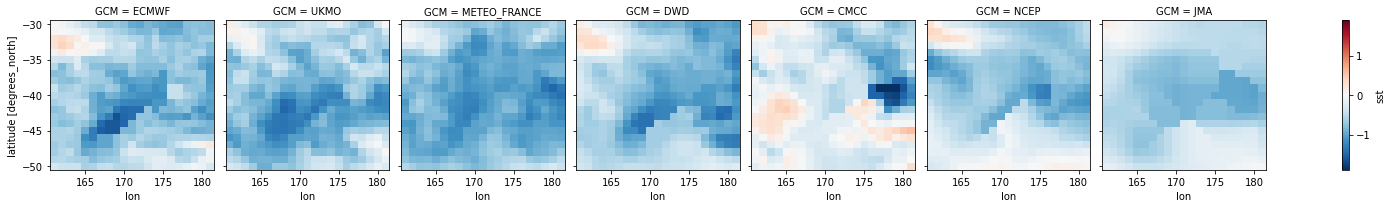

In [38]:
MME.isel(time=0, step=0)[varname].plot(col='GCM')

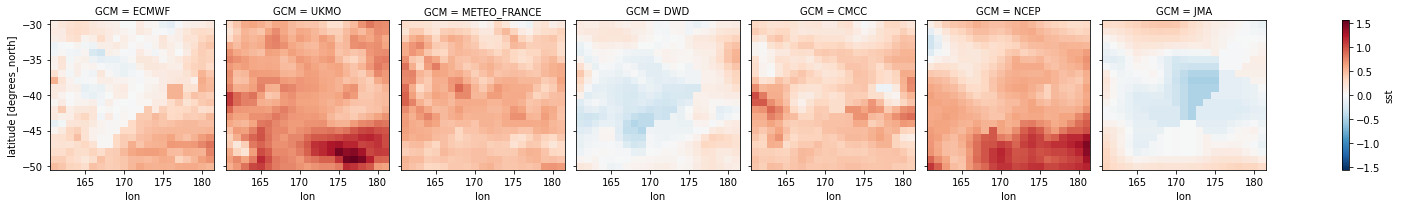

In [39]:
MME.isel(time=-1, step=0)[varname].plot(col='GCM')

### Now, if `obs_to_1deg` is set to False, it means that the MME needs to be interpolated onto the obs dataset grid 

In [40]:
MME = MME.interp_like(dset_obs[['lon','lat']])

In [41]:
if not(obs_to_1deg): 
    MME = MME.interp_like(dset_obs[['lon','lat']])

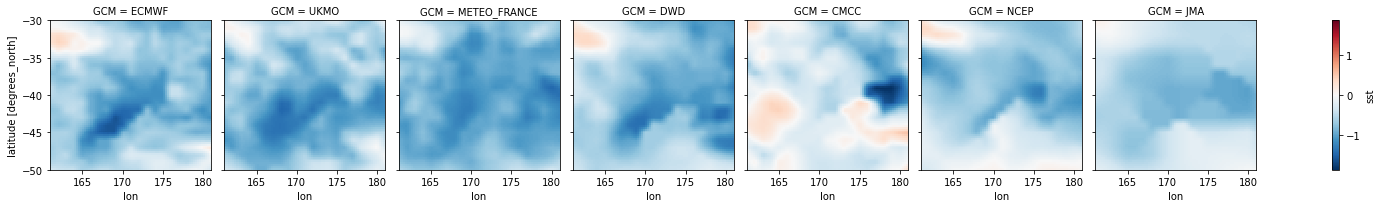

In [42]:
MME.isel(time=0, step=0)[varname].plot(col='GCM')

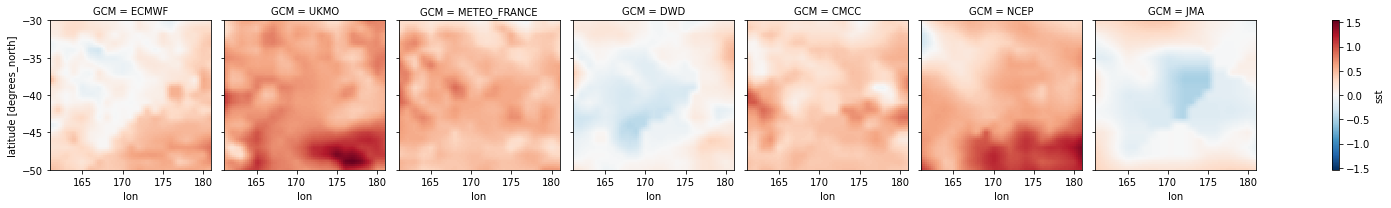

In [43]:
MME.isel(time=-1, step=0)[varname].plot(col='GCM')

### re-chunk, each chunk will take ~ 7 Mb in memory

In [44]:
MME = MME.chunk({'GCM':-1, 'time':-1, 'step':-1, 'lon':-1, 'lat':-1})

In [45]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 7, step: 3, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'JMA'
  * step     (step) int64 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(7, 286), meta=np.ndarray>
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 80, 80), meta=np.ndarray>

### add the ensemble mean to the set of GCMs

In [46]:
MME_mean = MME.mean('GCM')

In [47]:
MME_mean

<xarray.Dataset>
Dimensions:  (time: 286, step: 3, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 3 4 5
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, step, lat, lon) float64 dask.array<chunksize=(286, 3, 80, 80), meta=np.ndarray>

In [48]:
MME_mean = MME_mean.expand_dims({'GCM':['MME']})

In [49]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 7, step: 3, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'JMA'
  * step     (step) int64 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(7, 286), meta=np.ndarray>
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 80, 80), meta=np.ndarray>

In [50]:
if 'month' in MME.coords: 
    MME = MME.drop('month')

In [51]:
MME = xr.concat([MME, MME_mean], dim='GCM')

In [52]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 8, step: 3, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * step     (step) int64 3 4 5
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 80, 80), meta=np.ndarray>

In [53]:
with ProgressBar(): 
    MME = MME.compute() 

[########################################] | 100% Completed |  0.2s


### check all the dimensions and coordinates of the MME and the observational dataset 

In [54]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 8, step: 3, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * step     (step) int64 3 4 5
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, time, step, lat, lon) float64 -0.3641 -0.3785 ... 0.2385

In [55]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 286, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float64 0.03659 0.04152 0.01576 ... 0.1533 0.1861

### Plots each time step and each leadtime for 'visual' check 

In [56]:
# while 0: 
#     fpath = pathlib.Path('./tmp') 

#     if not fpath.exists(): 
#         fpath.mkdir(parents=True)

#     for t in range(len(MME.time)): 
#         for s in range(len(MME.step)): 
#             fg = MME.isel(time=t, step=s)['sst'].plot(col='GCM', vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)
#             fg.fig.savefig(f'./tmp/MME_time_{t}_step_{s}.png', facecolor='w') 
#             plt.close(fg.fig)

### we apply the observational land sea mask to the MME 

In [57]:
MME = MME * mask_obs

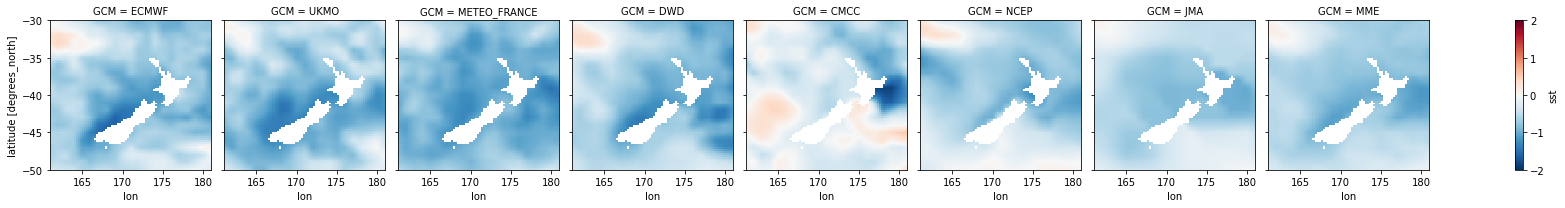

In [58]:
MME.isel(time=0, step=0)['sst'].plot(col='GCM', vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)

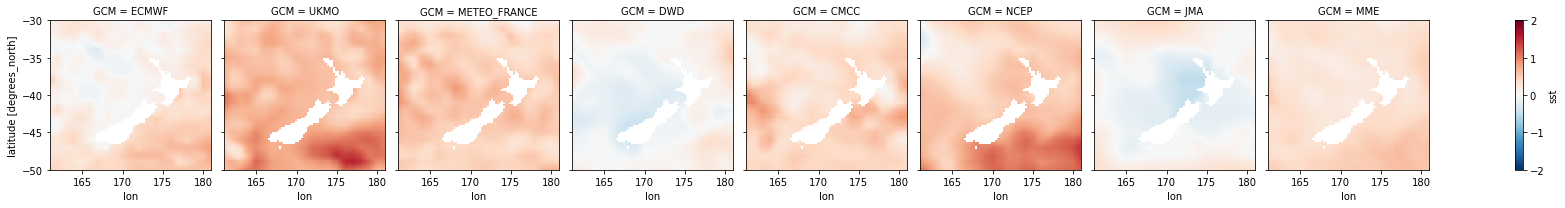

In [59]:
MME.isel(time=-1, step=0)['sst'].plot(col='GCM', vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)

### we can now just fill the missing values (land) with 0, as the subsequent operations do not support missing values 

In [60]:
MME = MME.fillna(0.)

In [61]:
dset_obs = dset_obs.fillna(0.)

In [62]:
with ProgressBar(): 
    MME = MME.compute() 
    dset_obs = dset_obs.compute() 

### process to make all the variables and dimension names compatible with climpred

In [63]:
MME = verification.process_for_climpred(MME)

In [64]:
MME

<xarray.Dataset>
Dimensions:  (GCM: 8, init: 286, lead: 3, lat: 80, lon: 80)
Coordinates:
  * init     (init) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * lead     (lead) int64 3 4 5
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float64 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, init, lead, lat, lon) float64 -0.3641 -0.3785 ... 0.2385

### re-chunk the MME 

In [65]:
MME = MME.chunk({'init':-1, 'lead':1, 'lat':-1, 'lon':-1})

### re-chunk the observations 

In [66]:
dset_obs = dset_obs.chunk({'time':-1, 'lat':-1, 'lon':-1})

In [67]:
dset_obs.chunks

Frozen({'time': (286,), 'lat': (80,), 'lon': (80,)})

### Try and create the hindcast ensemble over all the GCMs (including the MME)

In [68]:
hindcast = HindcastEnsemble(MME)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [69]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (GCM: 8, init: 286, lead: 3, lat: 80, lon: 80)
Coordinates:
 * init (init) object 1993-02-01 00:00:00 ... 2016-12-01 00:00:00
 * GCM (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
 * lead (lead) int64 3 4 5
 * lat (lat) float64 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
 * lon (lon) float64 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
 valid_time (lead, init) object 1993-05-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
 sst (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(8, 286, 1, 80, 80), meta=np.ndarray> Initialized Ensemble Dimensions: GCM : 8 init : 286 lead : 3 lat : 80 lon : 80 Coordinates: (6) init (init) object 1993-02-01 00:00:00 ... 2016-12-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 4, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) GCM (GCM) <U12 'ECMWF' 'UKMO' ... 'JMA' 'MME' array(['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA', 'MME'],
 dtype='<U12') lead (lead) int64 3 4 5 units : months standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([3, 4, 5]) lat (lat) float64 -49.88 -49.62 ... -30.38 -30.12 units : degrees_north long_name : latitude array([-49.875, -49.625, -49.375, -49.125, -48.875, -48.625, -48.375, -48.125,
 -47.875, -47.625, -47.375, -47.125, -46.875, -46.625, -46.375, -46.125,
 -45.875, -45.625, -45.375, -45.125, -44.875, -44.625, -44.375, -44.125,
 -43.875, -43.625, -43.375, -43.125, -42.875, -42.625, -42.375, -42.125,
 -41.875, -41.625, -41.375, -41.125, -40.875, -40.625, -40.375, -40.125,
 -39.875, -39.625, -39.375, -39.125, -38.875, -38.625, -38.375, -38.125,
 -37.875, -37.625, -37.375, -37.125, -36.875, -36.625, -36.375, -36.125,
 -35.875, -35.625, -35.375, -35.125, -34.875, -34.625, -34.375, -34.125,
 -33.875, -33.625, -33.375, -33.125, -32.875, -32.625, -32.375, -32.125,
 -31.875, -31.625, -31.375, -31.125, -30.875, -30.625, -30.375, -30.125]) lon (lon) float64 161.1 161.4 161.6 ... 180.6 180.9 array([161.125, 161.375, 161.625, 161.875, 162.125, 162.375, 162.625, 162.875,
 163.125, 163.375, 163.625, 163.875, 164.125, 164.375, 164.625, 164.875,
 165.125, 165.375, 165.625, 165.875, 166.125, 166.375, 166.625, 166.875,
 167.125, 167.375, 167.625, 167.875, 168.125, 168.375, 168.625, 168.875,
 169.125, 169.375, 169.625, 169.875, 170.125, 170.375, 170.625, 170.875,
 171.125, 171.375, 171.625, 171.875, 172.125, 172.375, 172.625, 172.875,
 173.125, 173.375, 173.625, 173.875, 174.125, 174.375, 174.625, 174.875,
 175.125, 175.375, 175.625, 175.875, 176.125, 176.375, 176.625, 176.875,
 177.125, 177.375, 177.625, 177.875, 178.125, 178.375, 178.625, 178.875,
 179.125, 179.375, 179.625, 179.875, 180.125, 180.375, 180.625, 180.875]) valid_time (lead, init) object 1993-05-01 00:00:00 ... 2017-05-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(1993, 5, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 6, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(199

### we then need to *repeat* the observation for each GCM (+MME) prior to merging 

In [70]:
dset_obs_repeat = xr.concat([dset_obs for i in range(len(MME['GCM']))], dim='GCM') 

In [71]:
dset_obs_repeat['GCM'] = MME['GCM']

In [72]:
dset_obs_repeat

<xarray.Dataset>
Dimensions:  (GCM: 8, time: 286, lat: 80, lon: 80)
Coordinates:
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 286, 80, 80), meta=np.ndarray>

### Now add the observations to the dataset 

In [73]:
hindcast = hindcast.add_observations(dset_obs_repeat)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


### first calculates the ACC *variability*, it's a good sanity check to see if some init months are out of wack 

In [74]:
ACC_variability = hindcast.verify(metric='acc', comparison='e2o', dim=['lat','lon'], alignment='maximize')

INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


### same thing for the RMSE 

In [75]:
RMSE_variability = hindcast.verify(metric='rmse', comparison='e2o', dim=['lat','lon'], alignment='maximize')

INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [76]:
with ProgressBar(): 
    ACC_variability = ACC_variability.compute()
    RMSE_variability = RMSE_variability.compute()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s


### ACC variability 

### most models "agree to disagree"

In [77]:
ACC_variability.lead.data

array([3, 4, 5])

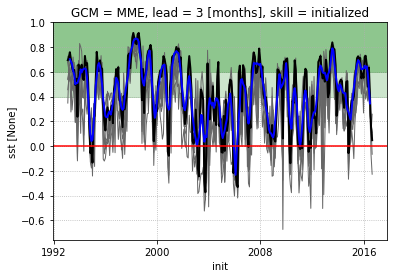

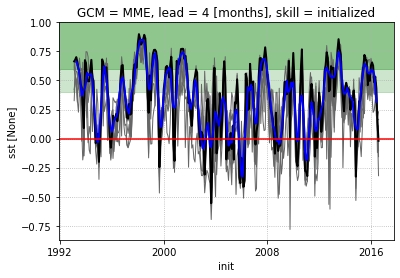

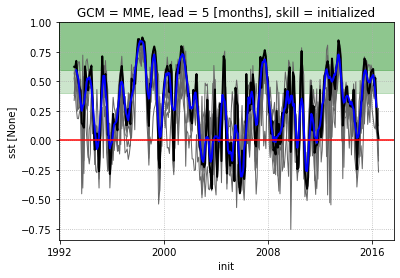

In [78]:
for lead in ACC_variability.lead.data: 
    f, ax = plt.subplots()
    for GCM in GCMs: 
        ACC_variability.sel(GCM=GCM, lead=lead)[varname].plot(ax=ax, lw=1, color='0.4')
    ACC_variability.sel(GCM="MME", lead=lead)[varname].plot(ax=ax, color='k', lw=2)
    ACC_variability.sel(GCM="MME", lead=lead)[varname].rolling({'init':5}, center=True).mean().plot(ax=ax, color='b', lw=2)
    ax.grid(ls=':')
    ax.axhspan(0.4, 1, color='g', alpha=0.2)
    ax.axhspan(0.6, 1, color='g', alpha=0.3)
    ax.set_ylim(None, 1)
    ax.axhline(0, color='r')
    f.savefig(fig_path.joinpath(f'ACC_variability_{period}_C3S_{domain_name}_domain_{varname}_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 
        

## extract the MME ACC variability, we could use it later to investigate what controls it (ENSO, etc)

In [79]:
MME_ACC_variability = ACC_variability.sel(GCM='MME', lead=ACC_variability.lead.min())[varname]

In [80]:
MME_ACC_variability.to_netcdf(f'../../outputs/MME_ACC_variability_{varname}_{period}.nc')

### Now calculates the ACC for all init times, along lat and lon 

In [81]:
ACC = hindcast.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


### same thing for the RMSE

In [82]:
RMSE = hindcast.verify(metric='rmse', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [83]:
with ProgressBar(): 
    ACC = ACC.compute()

[########################################] | 100% Completed |  0.5s


In [84]:
with ProgressBar(): 
    RMSE = RMSE.compute()

[########################################] | 100% Completed |  0.3s


In [85]:
ACC

<xarray.Dataset>
Dimensions:  (lead: 3, GCM: 8)
Coordinates:
  * lead     (lead) int64 3 4 5
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
    skill    <U11 'initialized'
Data variables:
    sst      (lead, GCM) float64 0.4057 0.3955 0.3647 ... 0.2717 0.2496 0.303
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     286
    alignment:                     maximize
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           ['init', 'lat', 'lon']
    reference:                     []

In [86]:
RMSE

<xarray.Dataset>
Dimensions:  (lead: 3, GCM: 8)
Coordinates:
  * lead     (lead) int64 3 4 5
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
    skill    <U11 'initialized'
Data variables:
    sst      (lead, GCM) float64 0.4684 0.4821 0.4889 ... 0.5243 0.5077 0.4721
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     286
    alignment:                     maximize
    metric:                        rmse
    comparison:                    e2o
    dim:                           ['init', 'lat', 'lon']
    reference:                     []

## casts ACC and RMSE xarray datasets to pandas dataframes 

In [87]:
ACC_df = ACC[varname].to_dataframe()[varname].unstack()

In [88]:
RMSE_df = RMSE[varname].to_dataframe()[varname].unstack()

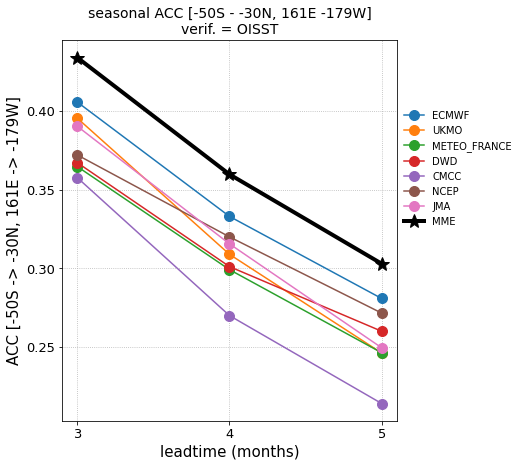

In [91]:
f, ax = plt.subplots(figsize=(6,7))
ACC_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
ACC_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(ACC.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} ACC [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

plt.legend(loc=(1.01, 0.5), frameon=False); 

f.savefig(fig_path.joinpath(f'ACC_{period}_C3S_{domain_name}_domain_{varname}_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

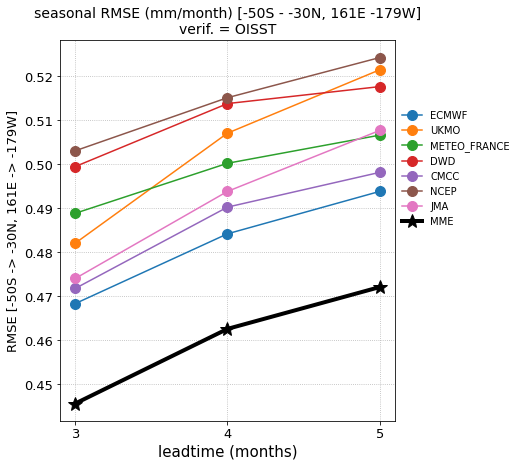

In [93]:
f, ax = plt.subplots(figsize=(6,7))
RMSE_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
RMSE_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"RMSE [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=13);
ax.set_xticks(RMSE.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} RMSE (mm/month) [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 


f.savefig(fig_path.joinpath(f'RMSE_{period}_C3S_{domain_name}_domain_{varname}_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### ACC per month 

In [94]:
ACC_per_month = []

for label, group in MME.groupby('init.month'):
    
    print(f"calculating metric for month {label}\n")

    hindcast_month = HindcastEnsemble(group)

    hindcast_month = hindcast_month.add_observations(dset_obs_repeat)

    skill_monthly = hindcast_month.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')
    
    with ProgressBar(): 
        
        skill_monthly = skill_monthly.compute()

    ACC_per_month.append(skill_monthly)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00


calculating metric for month 1



INFO:root:initialized | lead: 04 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-06-01 00:00:00-2016-06-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 2



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 3



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 4



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 5



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 6



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 7



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 8



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-08-01 00:00:00-2015-08-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 9



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-09-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 10



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 11



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 12



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00


[########################################] | 100% Completed |  0.1s


In [95]:
ACC_per_month = xr.concat(ACC_per_month, dim='month') 

In [96]:
ACC_per_month['month'] = (('month'), np.arange(12)+1)

In [97]:
ACC_per_month.lead.data[::-1]

array([5, 4, 3])

In [98]:
vmin = 0.3
vmax = 0.8

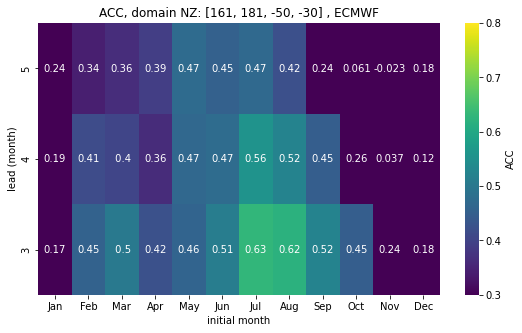

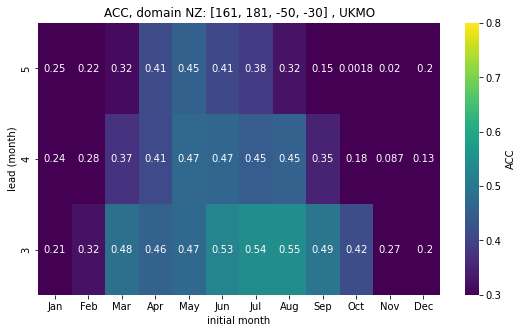

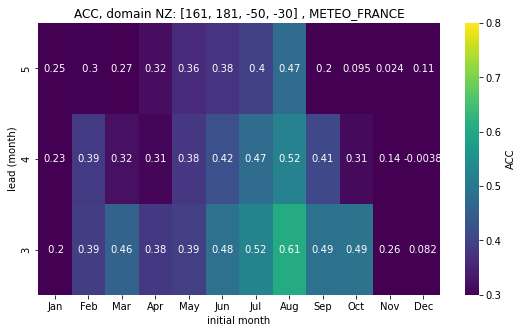

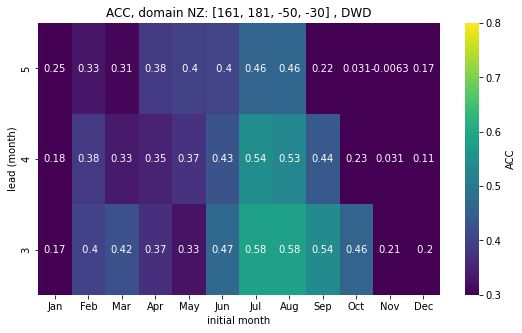

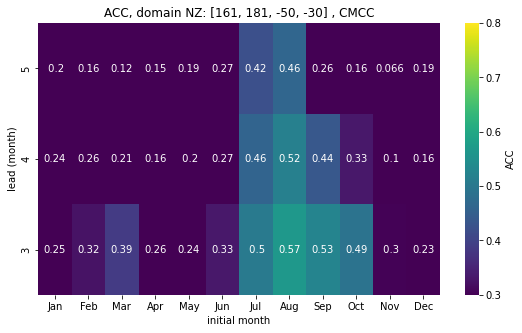

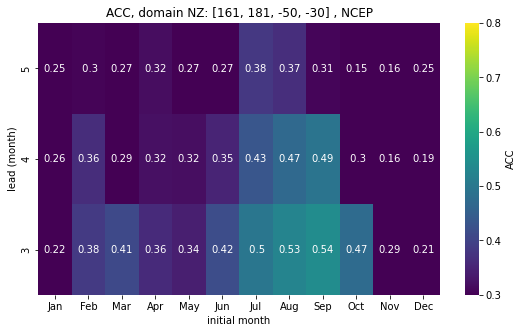

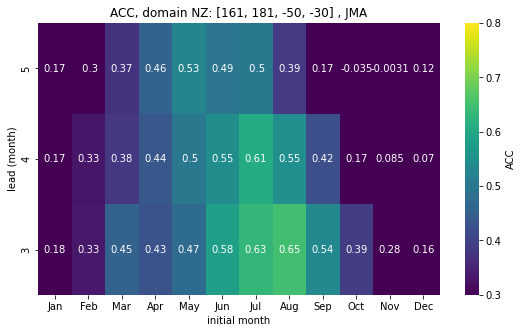

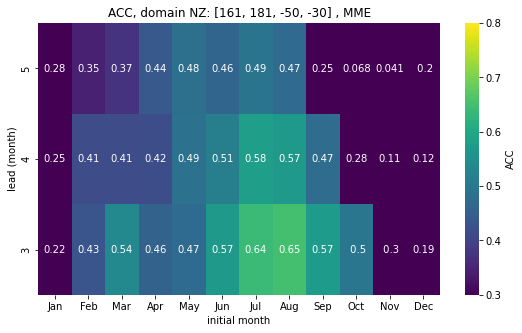

In [99]:
for GCM in GCMs + ['MME']:
    f, ax = plt.subplots(figsize=(9,5)); 
    _ = sns.heatmap(ACC_per_month.sel(GCM=GCM)[varname].sortby('lead', ascending=False).transpose(), ax=ax, annot=True, fmt="4.2", cmap='viridis', vmin=vmin, vmax=vmax);
    ax.set_title(f'ACC, domain {domain_name}: {domain} , {GCM}')
    ax.set_yticklabels(ACC_per_month.lead.data[::-1]); 
    ax.set_ylabel('lead (month)');
    ax.set_xticklabels(month_abbr[1:]);
    ax.set_xlabel('initial month'); 
    f.axes[-1].set_ylabel('ACC');
    # f.savefig(fig_path.joinpath(f'{period}_dependent_ACC_{GCM}_{domain_name}_domain_{varname}.png'),dpi=200, bbox_inches='tight', facecolor='w')

### correlation maps 

In [100]:
R_map = hindcast.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')

INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [101]:
with ProgressBar(): 
    R_map = R_map.compute()

[########################################] | 100% Completed |  0.5s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


### correlation per month 

In [102]:
R_map_per_month = []

for label, group in MME.groupby('init.month'):
    
    print(f"calculating metric for month {label}\n")

    hindcast_month = HindcastEnsemble(group)

    hindcast_month = hindcast_month.add_observations(dset_obs_repeat)
    
    R_m = hindcast_month.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')
    
    with ProgressBar(): 
        
        R_m = R_m.compute()

    R_map_per_month.append(R_m)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-06-01 00:00:00-2016-06-01 00:00:00


calculating metric for month 1

[                                        ] | 0% Completed |  0.0s

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 2



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 3



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 4



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 5



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 6



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 7



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 8



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-08-01 00:00:00-2015-08-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 9



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-09-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 10



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 11



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00


[########################################] | 100% Completed |  0.1s


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


calculating metric for month 12



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
INFO:root:initialized | lead: 03 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00


[########################################] | 100% Completed |  0.1s


In [103]:
R_map_per_month = xr.concat(R_map_per_month, dim='month') 

In [104]:
R_map_per_month['month'] = (('month'), np.arange(12)+1)

### choose the colormap 

In [107]:
cmap = cmocean.cm.balance

In [108]:
cmap.set_bad('0.8')

In [109]:
MME.lead.data

array([3, 4, 5])

In [110]:
R_map_per_month.to_netcdf(f'../../outputs/SST/Correlation_maps_per_init_month_{period}_{varname}_{use_verif}_verif.nc')

In [111]:
MME.GCM.data

array(['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA',
       'MME'], dtype='<U12')

In [121]:
levels=np.arange(-1, 1.1, 0.1)

In [122]:
for gcm in MME.GCM.data: 
    
    for lead in MME.lead.data:

        fg = R_map_per_month.sel(GCM=gcm,lead=lead)[varname].plot.contourf(levels=levels, col='month',col_wrap=4, \
                                                    subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)}, 
                                                    transform=ccrs.PlateCarree(), 
                                                    cmap=cmap)
        [ax.coastlines() for ax in fg.axes.flat];

        for i, ax in enumerate(fg.axes.flat): 

            ax.set_title(f"{gcm}, Init.:{month_abbr[i+1]}\nlead: {lead} {period}", fontsize=10)

        fg.fig.savefig(fig_path.joinpath(f'R_map_{gcm}_per_init_month_{period}_lead_{lead}_{domain_name}_domain_{varname}.png'), dpi=200, bbox_inches='tight',facecolor='w');
        
        plt.close(fg.fig)
        
        clear_output(wait=True)

### Now map the correlation coefficients for DJF and JJA target seasons 

In [153]:
GCM = 'MME'

In [154]:
vmin = -1
vmax = 1 
step = 0.1

In [155]:
cbar_kwargs={'shrink':0.9, 
             'orientation':'vertical', 
             'aspect':20, 
             'label':"Pearson's R", 
             'ticks':np.arange(vmin, vmax+step*2, step*2), 
             'boundaries':np.arange(vmin, vmax+step*2, step*2)}

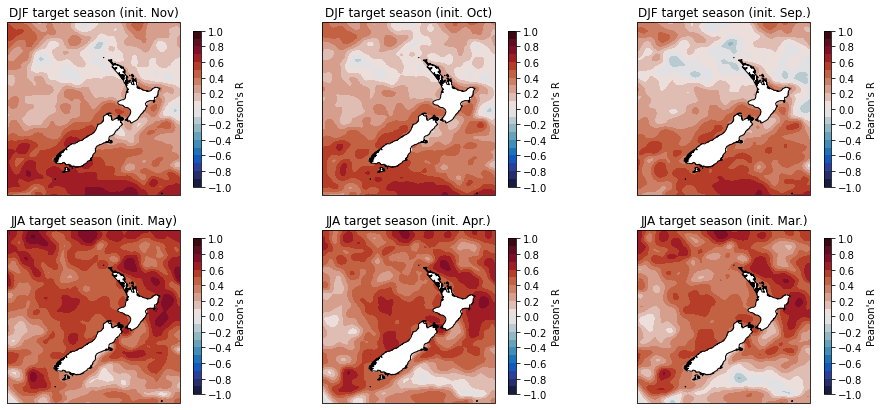

In [151]:
f, axes = plt.subplots(figsize=(16,7), nrows=2, ncols=3, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

R_map_per_month.sel(month=11, lead=3, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[0,0], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[0,0].set_title('DJF target season (init. Nov)')

axes[0,0].coastlines(resolution='10m')

R_map_per_month.sel(month=10, lead=4, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[0,1], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[0,1].set_title('DJF target season (init. Oct)')

axes[0,1].coastlines(resolution='10m')

R_map_per_month.sel(month=9, lead=5, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[0,2], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[0,2].set_title('DJF target season (init. Sep.)')

axes[0,2].coastlines(resolution='10m')


R_map_per_month.sel(month=5, lead=3, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[1,0], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[1,0].set_title('JJA target season (init. May)')

axes[1,0].coastlines(resolution='10m')

R_map_per_month.sel(month=4, lead=4, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[1,1], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[1,1].set_title('JJA target season (init. Apr.)')

axes[1,1].coastlines(resolution='10m')

R_map_per_month.sel(month=3, lead=5, GCM=GCM)[varname].plot.contourf(levels=levels, cmap=cmap, ax=axes[1,2], transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

axes[1,2].set_title('JJA target season (init. Mar.)')

axes[1,2].coastlines(resolution='10m')

f.savefig(fig_path.joinpath(f"R_maps_DJF_JJA_{varname}_{domain_name}_{GCM}.png"), dpi=200, bbox_inches='tight', facecolor='w')
f.savefig(fig_path.joinpath(f"R_maps_DJF_JJA_{varname}_{domain_name}_{GCM}.pdf"), bbox_inches='tight', facecolor='w')

In [ ]:
R_map_per_month.sel(month=6, lead=5, GCM='ECMWF')['sst'].plot(vmin=0, vmax=1, cmap=cmap)

In [ ]:
import cmocean

In [ ]:
cmap = cmocean.cm.tempo

In [ ]:
cmap.set_under('0.2', alpha=0.5)

In [ ]:
R_map.GCM.data

In [ ]:
vmin = 0.0
vmax = 1 
step = 0.1

In [ ]:
cbar_kwargs={'shrink':0.5, 
             'orientation':'horizontal', 
             'aspect':50, 
             'label':"Pearson's R", 
             'ticks':np.arange(vmin, vmax+step, step), 
             'boundaries':np.arange(vmin, vmax+step, step)}

In [ ]:
R_map['sst'] = utils.interpolate_NaN_da(R_map['sst'])

In [ ]:
import cartopy.feature as cfeature

In [ ]:
for GCM in R_map.GCM.data:
    
    fg = R_map.sel(GCM=GCM)[varname].plot.contourf(col='lead', levels=np.arange(0,0.9,0.1), cmap=cmap, \
                                                  subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)}, 
                                                 transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs) 


    # [ax.coastlines() for ax in fg.axes.flat];
    [ax.add_feature(cfeature.LAND) for ax in fg.axes.flat]
    

    axes = fg.axes.flat

#     [axes[i].set_title(f"R, {GCM}: {i + 1} months lead") for i in range(len(axes))]; 

    fg.fig.savefig(f'../../figures/validation/R_map_{GCM}_all_months_{period}_{domain_name}_domain_{varname}.png', dpi=200, bbox_inches='tight',facecolor='w'); 

In [ ]:
R_map

In [ ]:
cbar_kwargs = {'shrink':0.5, 'label':'R'}

In [ ]:
for l in R_map['lead'].data: 
    f, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    R_map.sel(GCM='MME',lead=l)['sst'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=np.arange(-1, 1 + 0.1, 0.1), cmap='RdBu_r', cbar_kwargs=cbar_kwargs)
    cs = R_map.sel(GCM='MME',lead=l)['sst'].plot.contour(ax=ax, linewidths=0.5, transform=ccrs.PlateCarree(), levels=np.arange(-1, 1 + 0.1, 0.1), colors='0.2')
    plt.clabel(cs, fmt="%4.1f", colors='k')
    ax.set_title(f"MME vs OISSTv2, lead: {l} months")
    ax.coastlines()
    f.savefig(f'./tmp_figures/MME_{l}.png', dpi=100, facecolor='w', bbox_inches='tight')

In [ ]:
# R_map = hindcast.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')

In [ ]:
predictions = hindcast.get_initialized()

In [ ]:
predictions

In [ ]:
observations = hindcast.get_observations()

In [ ]:
season_end = 3

In [ ]:
observations_seasonal = observations.sel(time=(observations.time.dt.month == season_end))

In [ ]:
observations_seasonal

In [ ]:
hindcast_seasonal = HindcastEnsemble(predictions)

In [ ]:
hindcast_seasonal = hindcast_seasonal.add_observations(observations_seasonal)

In [ ]:
R_map = hindcast_seasonal.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')

In [ ]:
R_map.sel(GCM='ECMWF')['sst'].plot.contourf(col='lead', cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1))

In [ ]:
R_map.sel(GCM='DWD')['sst'].plot.contourf(col='lead', cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1))

In [ ]:
R_map.sel(GCM='MME')['sst'].plot.contourf(col='lead', cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1))

In [ ]:
hindcast.time

### get NINO

In [ ]:
nino = verification.get_CPC_NINO(sst='oisst')

In [ ]:
nino.plot()

In [ ]:
nino = nino.loc['1993':'2016',:]

In [ ]:
el_nino = nino.loc[nino.loc[:,'NINO3.4'] >= 0.7,:]

In [ ]:
la_nina = nino.loc[nino.loc[:,'NINO3.4'] <= -0.7,:]

In [ ]:
neutral = nino.loc[(nino.loc[:,'NINO3.4'] > -0.7) & (nino.loc[:,'NINO3.4'] < 0.7),:]

In [ ]:
def series_to_xarray(ts): 
    ts = ts.to_xarray()
    ts = ts.rename({'index':'init'})
    return ts

In [ ]:
enso = series_to_xarray(nino)

In [ ]:
el_nino = series_to_xarray(el_nino)

In [ ]:
la_nina = series_to_xarray(la_nina)

In [ ]:
neutral = series_to_xarray(neutral)

In [ ]:
ACC_nino = (hindcast.sel(init=el_nino.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_nina = (hindcast.sel(init=la_nina.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_neutral = (hindcast.sel(init=neutral.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_nino = ACC_nino.compute()
    ACC_nina = ACC_nina.compute()
    ACC_neutral = ACC_neutral.compute()

In [ ]:
ACC_nino_df = ACC_nino[varname].to_dataframe()[varname].unstack()
ACC_nina_df = ACC_nina[varname].to_dataframe()[varname].unstack()
ACC_neutral_df = ACC_neutral[varname].to_dataframe()[varname].unstack()

In [ ]:
ACC_nino_df

In [ ]:
ACC_neutral_df

In [ ]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_nino_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='NINO', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_nina_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='NINA', lw=4)

# # ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
# ACC_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)

# ax.legend()
# ax.set_xlabel('leadtime (months)', fontsize=15);
# ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
# ax.set_xticks(MME.lead.data)
# ax.grid(ls=':')
# # ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# # # ax.set_ylim(0.15, 0.45)

# plt.legend(loc=(1.01, 0.5), frameon=False); 

# ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

# f.savefig(f'../../figures/validation/ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_ENSO_{varname}.png', dpi=200, bbox_inches='tight', facecolor='w'); 

### loads the monthly SST and calculate anomalies  

In [ ]:
sst_name = 'ersst'
# sst_name = 'oisst'

In [ ]:
if sst_name == 'ersst': 
    url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
    # drop an unnecessary variable which complicates some operations
    sst = xr.open_dataset(url, drop_variables=["time_bnds"])
    # will take a minute or two to complete
    sst = sst.sel(time=slice("1993", "2016")).load()
    # calculates the anomalies 
    sst = (sst.groupby(sst.time.dt.month) - sst.groupby(sst.time.dt.month).mean('time')).drop('month')
    sst['sst_detrend'] = detrend_dim(sst['sst'], 'time')
    sst = sst.sortby('lat')
elif sst_name == 'oisst': 
    sst = xr.open_dataset('/media/nicolasf/END19101/ICU/data/SST/NOAA_OISSTv2/monthly/OISST_v2_anomalies.nc')
    # data munging on the time index 
    sst['time'] = sst['time'].to_index() - pd.offsets.MonthBegin()

In [ ]:
sst = sst.rename({"time":"init"})

In [ ]:
sst

In [ ]:
ACC_variability

In [ ]:
R_l = []
for lead in MME.lead.data:
    sst_l, acc_l = xr.align(sst['sst_detrend'], ACC_variability.sel(lead=lead)['precip'])
    R = xr.corr(sst_l, acc_l, dim='init')
    with ProgressBar(): 
        R = R.compute()
    R_l.append(R.expand_dims(dim={'lead':[lead]}))

In [ ]:
R_l = xr.concat(R_l, dim='lead')

In [ ]:
R_l.sel(GCM='MME').plot(col='lead')

In [ ]:
R_l.sel(GCM='ECMWF').plot(col='lead')

In [ ]:
R_l.sel(GCM='UKMO').plot(col='lead')

In [ ]:
ts = ACC_variability.sel(GCM='MME')

In [ ]:
ts = ts.sel(lead=MME.lead.min())

In [ ]:
ts = ts['precip'].to_dataframe()[['precip']]

In [ ]:
low_acc = ts.loc[ts.loc[:,'precip'] <= 0]

In [ ]:
high_acc = ts.loc[ts.loc[:,'precip'] > 0.8]

In [ ]:
import cmocean

In [ ]:
cmap = cmocean.cm.balance

In [ ]:
high_acc.index

In [ ]:
sst.sel(init=high_acc.index, lat=slice(-35, 35), lon=slice(40, 290)).mean('init')['sst_detrend'].plot.contourf(levels=np.arange(-1, 1.1, 0.1), cmap=cmap) 

In [ ]:
sst_high = sst.sel(init=high_acc.index).mean('init')['sst_detrend']

In [ ]:
sst.sel(init=low_acc.index, lat=slice(-35, 35), lon=slice(40, 290)).mean('init')['sst_detrend'].plot.contourf(levels=np.arange(-1, 1.1, 0.1), cmap=cmap) 

In [ ]:
sst_low = sst.sel(init=low_acc.index).mean('init')['sst_detrend']

In [ ]:
(sst_low - sst_high).sel(lat=slice(-35, 35), lon=slice(40, 290)).plot.contourf(levels=np.arange(-1, 1.1, 0.1), cmap=cmap) 

In [ ]:
(sst_high - sst_low).plot.contourf(levels=np.arange(-1, 1.1, 0.1), cmap=cmap) 

In [ ]:
EMI = pd.read_csv('./EMI.csv', index_col=0, parse_dates=True)

In [ ]:
EMI.index.name = 'index'

In [ ]:
EMI = EMI.loc[:,['EMIstd']]

In [ ]:
EMI = EMI.loc['1993':'2016',:]

In [ ]:
EMI_pos = EMI.loc[EMI.loc[:,'EMIstd'] > 1,:]

In [ ]:
EMI_neg = EMI.loc[EMI.loc[:,'EMIstd'] < -1,:]

In [ ]:
EMI_neutral = EMI.loc[(EMI.loc[:,'EMIstd'] >= -1) & (EMI.loc[:,'EMIstd'] <= 1),:]

In [ ]:
ACC_EMI_pos = (hindcast.sel(init=EMI_pos.index)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_EMI_neg = (hindcast.sel(init=EMI_neg.index)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_EMI_neutral = (hindcast.sel(init=EMI_neutral.index)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_EMI_pos = ACC_EMI_pos.compute()
    ACC_EMI_neg = ACC_EMI_neg.compute()
    ACC_EMI_neutral = ACC_EMI_neutral.compute()

In [ ]:
ACC_EMI_pos_df = ACC_EMI_pos['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_EMI_neg_df = ACC_EMI_neg['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_EMI_neutral_df = ACC_EMI_neutral['precip'].to_dataframe()['precip'].unstack()

In [ ]:
f, ax = plt.subplots()
ACC_EMI_pos_df.loc[:,'MME'].plot(ax=ax, marker='o', color='r')
ACC_EMI_neg_df.loc[:,'MME'].plot(ax=ax, marker='o', color='b')
ACC_EMI_neutral_df.loc[:,'MME'].plot(ax=ax, marker='o', color='0.5')

In [ ]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_EMI_pos_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='Positive EMI', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_EMI_neg_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='Negative EMI', lw=4)

# ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
ACC_EMI_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)


ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(MME.lead.data)
ax.grid(ls=':')
# ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# # ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 

ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

f.savefig(f'../../figures/validation/ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_EMI.png', dpi=200, bbox_inches='tight', facecolor='w'); 

In [ ]:
sst.sel(init=EMI_neg.index).mean('init')['sst'].plot()

In [ ]:
sst.sel(init=EMI_pos.index).mean('init')['sst'].plot()

In [ ]:
sst.sel(init=la_nina.init).mean('init')['sst'].plot()

In [ ]:
sst.sel(init=el_nino.init).mean('init')['sst'].plot()